# Imports

In [ ]:
import tensorflow as tf
from typing import Optional, Tuple
import networkx as nx
import os, pickle
import numpy as np
import scipy.sparse as sp
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from graph import ZoneTransformer
from cluster_visualization import visualize_clusters

In [2]:
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false --tf_xla_auto_jit=0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [3]:
print("GPUs:", tf.config.list_physical_devices('GPU'))

try:
    tf.keras.mixed_precision.set_global_policy('float32')
except Exception:
    pass

tf.config.optimizer.set_jit(False)
tf.config.run_functions_eagerly(False)


GPUs: []


# Feature Encoding

In [4]:
def print_attrs(path):
    with open(path, "rb") as f:
        g = pickle.load(f)
        for _, attrs in g.nodes(data=True):
            print(attrs)
            break

In [5]:
print_attrs("graphs/graph_match2499719_team1609.pkl")

{'zone_name': 'LEFT_WING_DEF_BOX', 'x_center': np.float64(3.0), 'y_center': np.float64(90.5), 'in_deg': 0, 'out_deg': 0, 'event_distribution': [0, 0, 0, 0], 'unique_players': 0, 'event_count': 0, 'most_common_event': None, 'role_distribution': [0, 0, 0, 0]}


In [6]:
def build_vocab(source):
    event_vocab, zone_vocab = set(), set()
    if isinstance(source, str):
        file_paths = [os.path.join(source, f) for f in os.listdir(source)
                      if os.path.isfile(os.path.join(source, f))]
    else:
        file_paths = list(source)

    for p in file_paths:
        with open(p, "rb") as f:
            g = pickle.load(f)
        for _, attrs in g.nodes(data=True):
            ev = attrs.get("most_common_event")
            zn = attrs.get("zone_name")
            if ev is not None: event_vocab.add(str(ev))
            if zn is not None: zone_vocab.add(str(zn))

    return sorted(event_vocab), sorted(zone_vocab)

event_vocab, zone_vocab = build_vocab('graphs')
print("Events: ", event_vocab)
print("Zones: ", zone_vocab)

Events:  ['DUEL', 'GOALKEEPER', 'PASS', 'SHOT']
Zones:  ['CENTER_ATT_PENALTY', 'CENTER_ATT_THIRD', 'CENTER_DEF_BOX', 'CENTER_DEF_PENALTY', 'CENTER_DEF_THIRD', 'CENTER_DEF_THIRD_DEEP', 'CENTER_MID_THIRD_ATT', 'CENTER_MID_THIRD_DEF', 'LEFT_HALF_ATT_PENALTY', 'LEFT_HALF_ATT_THIRD', 'LEFT_HALF_DEF_BOX', 'LEFT_HALF_DEF_PENALTY', 'LEFT_HALF_DEF_THIRD', 'LEFT_HALF_DEF_THIRD_DEEP', 'LEFT_HALF_MID_THIRD_ATT', 'LEFT_HALF_MID_THIRD_DEF', 'LEFT_WING_ATT_PENALTY', 'LEFT_WING_ATT_THIRD', 'LEFT_WING_DEF_BOX', 'LEFT_WING_DEF_PENALTY', 'LEFT_WING_DEF_THIRD', 'LEFT_WING_DEF_THIRD_DEEP', 'LEFT_WING_MID_THIRD_ATT', 'LEFT_WING_MID_THIRD_DEF', 'OUTSIDE', 'RIGHT_HALF_ATT_PENALTY', 'RIGHT_HALF_ATT_THIRD', 'RIGHT_HALF_DEF_BOX', 'RIGHT_HALF_DEF_PENALTY', 'RIGHT_HALF_DEF_THIRD', 'RIGHT_HALF_DEF_THIRD_DEEP', 'RIGHT_HALF_MID_THIRD_ATT', 'RIGHT_HALF_MID_THIRD_DEF', 'RIGHT_WING_ATT_PENALTY', 'RIGHT_WING_ATT_THIRD', 'RIGHT_WING_DEF_BOX', 'RIGHT_WING_DEF_PENALTY', 'RIGHT_WING_DEF_THIRD', 'RIGHT_WING_DEF_THIRD_DEEP', '

In [7]:
def encode_node_attributes(attrs, event_vocab, zone_vocab):
    event_onehot = np.zeros(len(event_vocab), dtype=np.float32)
    if attrs["most_common_event"] in event_vocab:
        event_onehot[event_vocab.index(attrs["most_common_event"])] = 1.0
    zone_onehot = np.zeros(len(zone_vocab), dtype=np.float32)
    if attrs["zone_name"] in zone_vocab:
        zone_onehot[zone_vocab.index(attrs["zone_name"])] = 1.0

    numeric = np.array([attrs["event_count"], attrs["unique_players"]], dtype=np.float32)
    role = np.array(attrs["role_distribution"], dtype=np.float32)

    return np.concatenate([numeric, role, event_onehot, zone_onehot])

# Helpers

In [8]:
def normalize_adj(adj):
    adj = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj.sum(1)).flatten()
    d_inv_sqrt = np.power(rowsum, -0.5, where=rowsum>0)
    D_inv_sqrt = sp.diags(d_inv_sqrt)

    return D_inv_sqrt @ adj @ D_inv_sqrt

def scipy_to_tf_sparse(mat):
    mat = mat.tocoo()
    indices = np.vstack((mat.row, mat.col)).T

    return tf.SparseTensor(indices, mat.data.astype(np.float32), mat.shape)

In [ ]:
def get_graph_embedding(path, encoder, event_vocab, zone_vocab):

    A_tf, A_dense, X = load_graph(path, event_vocab, zone_vocab)

    with open(path, "rb") as file:
        G = pickle.load(file)
    node_order = list(G.nodes)

    Z = encoder((X, A_tf), training=False).numpy()

    return Z, node_order, G

In [10]:
def cluster_graph_embedding(Z: np.ndarray, n_clusters: Optional[int] = None, random_state: int = 42):
    """Cluster a single graph's embeddings Z and return labels (len = n_nodes).
    If n_clusters is None, we use a simple heuristic based on graph size.
    """
    n = Z.shape[0]
    if n_clusters is None:
        k = max(2, min(12, int(np.ceil(np.sqrt(max(n, 1))/1.5))))
    else:
        k = int(n_clusters)
    km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
    clusters = km.fit_predict(Z)
    return clusters


In [11]:

def visualize_clusters_on_graph(G: nx.Graph, labels: np.ndarray, layout: str = "spring", title: Optional[str] = None, node_size: int = 140):
    nodes = list(G.nodes())
    if len(labels) != len(nodes):
        raise ValueError("labels length must equal number of nodes in G")

    if layout == "kamada":
        pos = nx.kamada_kawai_layout(G)
    elif layout == "embedding":
        raise ValueError("Use 'embedding' layout via visualize_with_embedding(...) below.")
    else:
        pos = nx.spring_layout(G, seed=42)

    n_clusters = int(labels.max()) + 1 if len(labels) else 1
    cmap = plt.get_cmap("tab20" if n_clusters > 10 else "tab10", max(n_clusters, 1))
    colors = [cmap(int(c)) for c in labels]

    plt.figure(figsize=(8, 6))
    nx.draw_networkx_edges(G, pos, alpha=0.25, width=0.8)
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=node_size, edgecolors="k", linewidths=0.3)

    # Optional: small zone labels if present
    zone_labels = {}
    for n in nodes:
        zname = G.nodes[n].get("zone_name")
        if isinstance(zname, str) and zname:
            zone_labels[n] = zname
    if zone_labels:
        nx.draw_networkx_labels(G, pos, labels=zone_labels, font_size=7)

    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()


# Data Loading

In [12]:
def load_data(directory, event_vocab, zone_vocab):
    file_name = os.listdir(directory)[0]
    with open(os.path.join(directory, file_name), 'rb') as f:
        graph_data = pickle.load(f)
    adj = nx.adjacency_matrix(graph_data)
    features = [encode_node_attributes(attrs, event_vocab, zone_vocab)
                for _, attrs in graph_data.nodes(data=True)]
    X = np.vstack(features)

    return adj, X

In [13]:
def list_graph_paths(directory):
    paths = [os.path.join(directory, f) for f in os.listdir(directory)
             if os.path.isfile(os.path.join(directory, f))]
    paths.sort()
    return paths

In [14]:
def load_graph(path, event_vocab, zone_vocab):
    with open(path, "rb") as f:
        graph = pickle.load(f)
    A = nx.adjacency_matrix(graph)
    X = np.stack([
        encode_node_attributes(attrs, event_vocab, zone_vocab)
        for _, attrs in graph.nodes(data=True)
    ]).astype(np.float32)

    A_norm = normalize_adj(A)
    A_tf = scipy_to_tf_sparse(A_norm)
    A_dense = np.asarray(A_norm.todense(), dtype=np.float32)

    return A_tf, A_dense, X

# Model

In [15]:
class GraphConvolution(tf.keras.layers.Layer):
    def __init__(self, units: int, activation: Optional[str] = "relu", dropout: float = 0.0, use_bias: bool = True, name: str = None):
        super().__init__(name=name)
        self.units = units
        self.use_bias = use_bias
        self.activation = tf.keras.activations.get(activation)
        self.dropout = tf.keras.layers.Dropout(dropout) if dropout and dropout > 0.0 else None

    def build(self, input_shape: Tuple[Tuple[int, int], Tuple[int, int]]):
        x_shape = input_shape[0]
        in_features = int(x_shape[-1])
        self.W = self.add_weight(
        name="weight",
        shape=(in_features, self.units),
        initializer="glorot_uniform",
        trainable=True
        )
        if self.use_bias:
            self.b = self.add_weight(
            name="bias",
            shape=(self.units,),
            initializer="zeros",
            trainable=True
        )
        else:
            self.b = None
        super().build(input_shape)

    def call(self, inputs, training: bool = False):
        x, A_hat = inputs
        if self.dropout is not None and training:
            x = self.dropout(x, training=training)
        support = tf.matmul(x, self.W)
        Z = tf.sparse.sparse_dense_matmul(A_hat, support)
        if self.b is not None: Z = Z + self.b

        return self.activation(Z) if self.activation is not None else Z

In [ ]:
class GAEEncoder(tf.keras.Model):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int, dropout: float = 0.0):
        super().__init__()
        self.gcn_hidden = GraphConvolution(hidden_dim, activation="relu", dropout=dropout, name="gcn_hidden")
        self.gcn_mu = GraphConvolution(latent_dim, activation=None, dropout=dropout, name="gcn_mu")

    def call(self, inputs, training: bool = False):
        X, A_hat = inputs
        H = self.gcn_hidden((X, A_hat), training=training)
        Z = self.gcn_mu((H, A_hat), training=training)

        return Z

In [17]:
class GAEFeatureDecoder(tf.keras.Model):
    def __init__(self, out_units, hidden_units: int = 64, activation: str = "relu", name: str = "Decoder"):
        super().__init__(name=name)
        self.d1 = tf.keras.layers.Dense(hidden_units, activation=activation)
        self.out = tf.keras.layers.Dense(out_units, activation=None)

    def call(self, Z, training=False):
        h = self.d1(Z, training=training)
        X_hat = self.out(h, training=training)

        return X_hat

# Training

In [18]:
sample_path = list_graph_paths("graphs")[0]
_, _, X_sample = load_graph(sample_path, event_vocab, zone_vocab)
input_dim = X_sample.shape[1]
encoder = GAEEncoder(input_dim=input_dim, hidden_dim=32, latent_dim=8, dropout=0.1)
feature_dim = int(X_sample.shape[1])
decoder = GAEFeatureDecoder(out_units=feature_dim, hidden_units=64)

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse = tf.keras.losses.MeanSquaredError()

In [ ]:
def train_step(X, A_tf, A_dense):
    with tf.GradientTape() as tape:
        Z = encoder((X, A_tf), training=True)
        X_hat = decoder(Z, training=True)
        if X_hat.shape[-1] != X.shape[-1]:
            decoder.out = tf.keras.layers.Dense(int(X.shape[-1]), activation=None)
            X_hat = decoder(Z, training=True)
        loss = mse(X, X_hat)

    vars = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss, vars)
    optimizer.apply_gradients(zip(grads, vars))

    return loss

In [21]:
all_paths = list_graph_paths("graphs")
random.Random(42).shuffle(all_paths)
cut = int(0.8 * len(all_paths))
train_paths, test_paths = all_paths[:cut], all_paths[cut:]
print(f"Train graphs: {len(train_paths)}, Test graphs: {len(test_paths)}")

Train graphs: 89, Test graphs: 23


In [22]:
for epoch in range(1, 30):
    train_losses = []
    for path in train_paths:
        A_tf, A_dense, X = load_graph(path, event_vocab, zone_vocab)
        loss = train_step(X, A_tf, A_dense)
        train_losses.append(loss.numpy())

    if epoch % 5 == 0 or epoch == 29:
        print(f"Epoch {epoch}, Train Loss: {tf.reduce_mean(train_losses):.4f}")

Epoch 5, Train Loss: 1.0021
Epoch 10, Train Loss: 0.8547
Epoch 15, Train Loss: 0.7113
Epoch 20, Train Loss: 0.6635
Epoch 25, Train Loss: 0.6529
Epoch 29, Train Loss: 0.6887


# Clustering

In [36]:
path = 'graphs/graph_match2499719_team1609.pkl'
Z, node_order, G = get_graph_embedding(path, encoder, event_vocab, zone_vocab)

clusters = cluster_graph_embedding(Z, 5, random.seed(42))
print(clusters)

[1 1 3 1 2 1 1 3 1 0 3 2 1 0 2 4 1 1 1 1 4 2 2 1 0 1 3 4 2 4 2 4 2 4 4 0 4
 4 4]


# Visualization

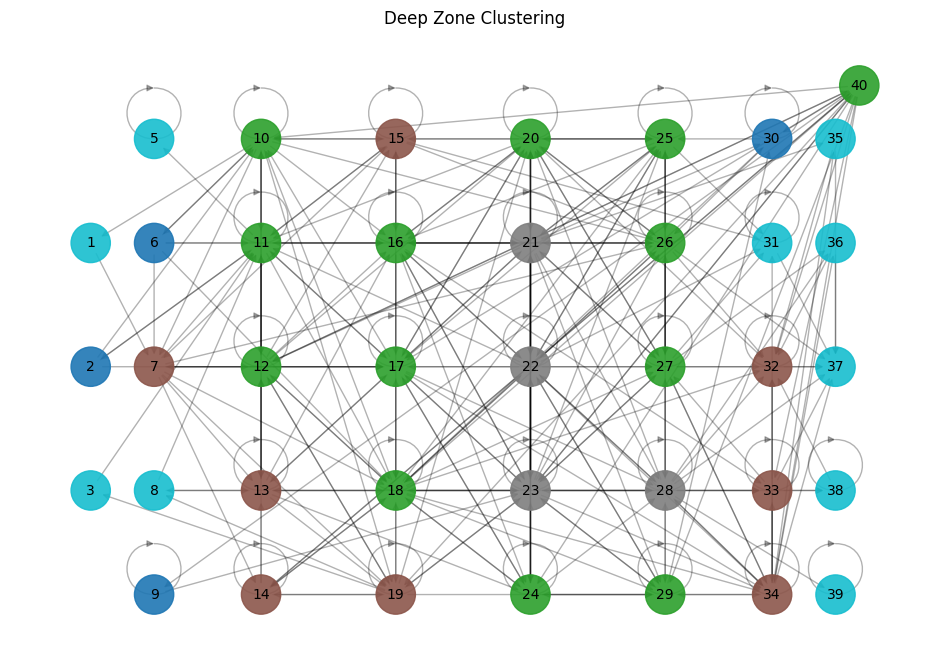

In [39]:
zt = ZoneTransformer()
visualize_clusters(G, Z, clusters, zt)

### NMI

In [23]:
import os
import re
import pickle
import numpy as np
from glob import glob
from itertools import combinations
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import normalize

# === 1. Find all graph files ===
graph_files = sorted(glob('./graphs/*.pkl'))
print(f"Found {len(graph_files)} graphs")

# === 2. Group by team ===
team_graphs = {}
pattern = re.compile(r'team(\d+)')

for f in graph_files:
    match = pattern.search(os.path.basename(f))
    if match:
        team_id = match.group(1)
        team_graphs.setdefault(team_id, []).append(f)

print("\nTeams found:")
for team, files in team_graphs.items():
    print(f"  Team {team}: {len(files)} matches")

# === 3. Compute mean NMI per team ===
team_nmi_summary = {}

for team, files in team_graphs.items():
    print(f"\n=== Processing Team {team} ===")

    cluster_labels = []

    for file in sorted(files):
        # with open(file, 'rb') as f:
        #     G = pickle.load(f)

        Z, node_order, G = get_graph_embedding(file, encoder, event_vocab, zone_vocab)

        labels = cluster_graph_embedding(Z, 5, random.seed(42))

        cluster_labels.append(labels)

    # Compute pairwise NMI between matches of this team
    nmi_scores = []
    for (labels_i, labels_j) in combinations(cluster_labels, 2):
        if len(labels_i) == len(labels_j):
            nmi_scores.append(normalized_mutual_info_score(labels_i, labels_j))

    # Store mean/std NMI
    if nmi_scores:
        mean_nmi = np.mean(nmi_scores)
        std_nmi = np.std(nmi_scores)
        team_nmi_summary[team] = (mean_nmi, std_nmi)
        print(f"Mean NMI: {mean_nmi:.4f}, Std: {std_nmi:.4f}")
    else:
        print("Not enough comparable matches (different #nodes or only one match).")

# === 4. Print final summary ===
print("\n=== Overall NMI Summary ===")
for team, (mean_nmi, std_nmi) in team_nmi_summary.items():
    print(f"Team {team}: Mean NMI = {mean_nmi:.4f}, Std = {std_nmi:.4f}")


/opt/anaconda3/envs/graphml/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 112 graphs

Teams found:
  Team 1609: 38 matches
  Team 1625: 37 matches
  Team 1612: 37 matches

=== Processing Team 1609 ===
Mean NMI: 0.4489, Std: 0.0711

=== Processing Team 1625 ===
Mean NMI: 0.4648, Std: 0.0857

=== Processing Team 1612 ===
Mean NMI: 0.4734, Std: 0.0701

=== Overall NMI Summary ===
Team 1609: Mean NMI = 0.4489, Std = 0.0711
Team 1625: Mean NMI = 0.4648, Std = 0.0857
Team 1612: Mean NMI = 0.4734, Std = 0.0701
